In [45]:
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from bmi_topography import Topography
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider, SpaceLargeScaleEroder
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask

# [SPACE large-scale](https://landlab.readthedocs.io/en/latest/reference/components/space.html#module-landlab.components.space.space_large_scale_eroder)

In [112]:
# import small DEM
topo = Topography(
    dem_type="SRTMGL1",
    south=43.971911,
    north=43.982382,
    west=-123.826646,
    east=-123.813606,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )
fname = topo.fetch()
dem = topo.load()
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    

/opt/tljh/user/envs/ivy/lib/python3.9/site-packages/bmi_topography/topography.py:26: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


In [113]:
grid = RasterModelGrid ((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), 30) # 30 meters
grid.add_field('topographic__elevation', elev, at = 'node')

num_rows, num_columns = grid.shape 
node_spacing = grid.dx

In [114]:
np.random.rand(len(grid.node_y)) / 10.

array([ 0.03427444,  0.00343564,  0.01176815, ...,  0.03278267,
        0.03213148,  0.05821393])

In [115]:
node_next_to_outlet = num_columns + 1
np.random.seed(seed=5000)

# get soil__depth, bedrock__elevation, topographic__elevation from previous models
_ = grid.add_zeros("soil__depth", at="node")
# grid.at_node["soil__depth"][grid.core_nodes] = 2.0
grid.at_node["soil__depth"][grid.core_nodes] = 1.0

# why do we divide by 10?
_ = grid.add_zeros("bedrock__elevation", at="node")
grid.at_node["bedrock__elevation"] += (
    grid.node_y / 10. + grid.node_x / 10. + np.random.rand(len(grid.node_y)) / 10.
)
grid.at_node["bedrock__elevation"][:] = grid.at_node["topographic__elevation"]
grid.at_node["topographic__elevation"][:] += grid.at_node["soil__depth"]

grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True,
    left_is_closed=True,
    right_is_closed=True,
    top_is_closed=True,
)

grid.set_watershed_boundary_condition_outlet_id(
    0, grid.at_node['topographic__elevation'], -9999.0
)

In [116]:
def all_keys(grid):
    for group in grid.groups:
        print(grid.keys(group))

In [118]:
flood_router = PriorityFloodFlowRouter(grid, flow_metric='D8', suppress_out = True)
space = SpaceLargeScaleEroder(
    grid,
    K_sed=0.03, # erodibility for sediment
    K_br=0.1, # erodibility for bedrock
)

In [119]:
timestep = 10.0
elapsed_time = 0.0
count = 0
run_time = 1e2
sed_flux = np.zeros(int(run_time // timestep))

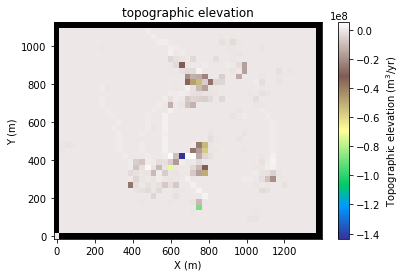

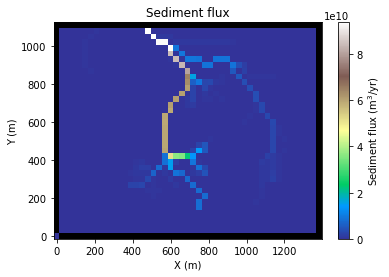

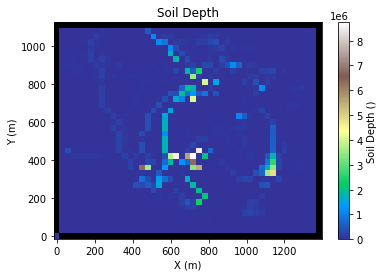

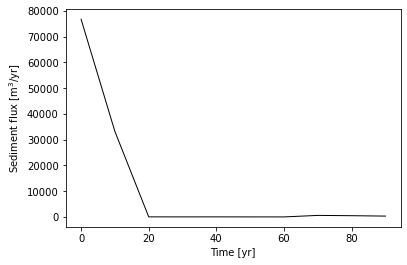

In [121]:
fig = plt.figure()
plot = plt.subplot()
_ = imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="topographic elevation",
    var_name="Topographic elevation",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)
_ = plt.figure()

_ = imshow_grid(
    grid,
    "sediment__flux",
    plot_name="Sediment flux",
    var_name="Sediment flux",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)
fig = plt.figure()

_ = imshow_grid(
    grid,
    "soil__depth",
    plot_name="Soil Depth",
    var_name="Soil Depth",
    var_units=r"",
    grid_units=("m", "m"),
    cmap="terrain",
)
fig = plt.figure()

sedfluxplot = plt.subplot()
_ = sedfluxplot.plot(np.arange(len(sed_flux)) * timestep, sed_flux, color="k", linewidth=1.0)
_ = sedfluxplot.set_xlabel("Time [yr]")
_ = sedfluxplot.set_ylabel(r"Sediment flux [m$^3$/yr]")

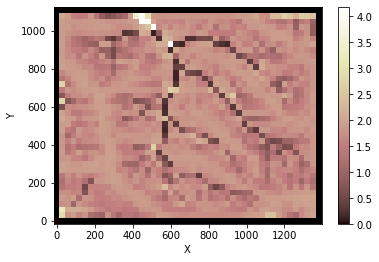

In [81]:
_ = imshow_grid(grid, "soil__depth")